In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import sklearn
import shap
%matplotlib inline
from xgboost import XGBClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay

In [92]:
plt.style.use("seaborn")

## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/Algeria_2021_access.csv")
IND_u= pd.read_csv('../Datasets/Algeria_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

0    679
1    323
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,1,1.0,2,5
1,2,5.0,1,1
2,2,2.0,3,5
3,2,1.0,2,1
4,2,5.0,2,4
...,...,...,...,...
997,2,2.0,2,2
998,2,2.0,2,5
999,2,2.0,3,3
1000,2,1.0,2,1


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,51,42,32,26,22
2,79,101,111,136,121
3,25,35,67,67,87


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

In [8]:
IND_a= IND_a.drop(columns= ["account_mob", "fin1_1a", "fin1_1b"])
IND_a

,account_fin,fin2,fin7,mobileowner,internetaccess
0,Yes,Yes,No,Yes,Yes
1,Yes,No,No,Yes,No
2,Yes,Yes,No,Yes,Yes
3,No,No,NaN,Yes,Yes
4,Yes,Yes,No,Yes,Yes
...,...,...,...,...,...
997,No,No,NaN,Yes,Yes
998,Yes,No,No,Yes,Yes
999,Yes,Yes,No,Yes,Yes
1000,Yes,Yes,No,Yes,Yes


In [9]:
IND_u= IND_u.drop(columns= ["fin1_1a", "fin1_1b", "fin26", "fin28","fin17b", "merchantpay_dig"])
IND_u

,fin4,fin5,fin8,fin9,fin10,fin10b,fin14_1,fin14a,fin14a1,fin14b,...,fin22b,fin30,fin31a,fin31b,fin32,fin37,fin38,saved,borrowed,anydigpayment
0,No,No,NaN,Yes,Yes,Yes,2,No,No,No,...,No,No,NaN,NaN,No,2,No,1,2,2
1,NaN,No,NaN,Yes,Yes,No,2,No,No,No,...,Yes,Yes,No,No,Yes,1,No,2,1,1
2,Yes,Yes,NaN,Yes,Yes,Yes,2,No,No,No,...,Yes,Yes,No,No,Yes,2,No,1,1,1
3,NaN,NaN,NaN,NaN,NaN,NaN,1,Yes,Yes,Yes,...,Yes,Yes,No,No,Yes,1,No,1,1,2
4,No,Yes,NaN,Yes,Yes,Yes,1,No,No,No,...,No,Yes,No,No,No,2,No,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,NaN,NaN,NaN,NaN,NaN,NaN,2,No,No,No,...,Yes,No,NaN,NaN,No,2,No,2,1,2
998,NaN,No,NaN,No,No,No,2,No,No,No,...,No,Yes,Yes,No,No,2,No,1,2,1
999,No,Yes,NaN,Yes,Yes,No,2,No,No,No,...,No,No,NaN,NaN,No,1,No,2,2,1
1000,No,No,NaN,No,No,No,2,No,No,No,...,Yes,No,NaN,NaN,No,2,No,2,1,2


## Implementing MCA

In [10]:
mca_a = prince.MCA(n_components=6)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6
0,-0.628470,0.090607,-0.096346,0.130438,-0.204211,0.002341
1,0.222327,0.687371,-0.628011,-0.839495,0.387556,-0.031669
2,-0.628470,0.090607,-0.096346,0.130438,-0.204211,0.002341
3,0.800580,-0.493620,0.038486,0.158538,-0.152305,-0.006933
4,-0.628470,0.090607,-0.096346,0.130438,-0.204211,0.002341
...,...,...,...,...,...,...
997,0.800580,-0.493620,0.038486,0.158538,-0.152305,-0.006933
998,-0.130311,-0.101881,-0.162675,0.112050,0.490984,-0.036926
999,-0.628470,0.090607,-0.096346,0.130438,-0.204211,0.002341
1000,-0.628470,0.090607,-0.096346,0.130438,-0.204211,0.002341


In [11]:
mca_u = prince.MCA(n_components=26)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC17,uPC18,uPC19,uPC20,uPC21,uPC22,uPC23,uPC24,uPC25,uPC26
0,0.144858,-0.027418,-0.295765,-0.471697,0.102070,0.213139,-0.048443,-0.042377,-0.022864,-0.133491,...,0.050928,-0.184839,-0.063128,0.011375,-0.086595,0.015954,0.019037,0.079893,-0.049421,0.017207
1,0.016411,-0.388439,0.061313,0.265652,-0.403896,-0.134988,0.006786,-0.214691,0.078500,0.094005,...,0.035766,-0.013316,0.087980,-0.022828,0.125914,-0.127313,-0.033785,0.003246,0.010669,-0.008013
2,0.799609,0.046481,-0.099486,0.098197,-0.091716,0.291538,-0.559772,-0.074547,0.003108,0.307413,...,-0.201859,0.175211,-0.064897,0.092922,0.053978,0.030449,0.036190,-0.024330,-0.054033,0.032317
3,0.668664,0.761000,0.270320,0.852075,-0.325133,-0.247031,-0.081246,0.684722,0.015421,-0.053316,...,-0.273512,-0.237305,0.346525,0.310296,-0.103222,-0.088559,-0.158238,0.102385,-0.043743,-0.066164
4,0.475268,-0.221775,-0.270574,-0.080637,0.244432,-0.062812,-0.070830,0.124252,0.045242,-0.136067,...,-0.033338,-0.192927,-0.042506,0.001667,0.015469,-0.012568,0.068975,-0.054809,-0.069237,-0.098920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,-0.573139,0.236997,-0.120565,0.170433,-0.139207,0.153131,-0.220517,-0.063576,0.146519,0.010869,...,0.008721,-0.009560,-0.014424,0.023613,-0.020305,-0.039384,0.043532,-0.003833,0.008053,0.001407
998,-0.142270,-0.082169,0.837604,0.006863,0.244006,0.070643,0.251434,-0.303813,0.163339,-0.423021,...,-0.308364,-0.101500,0.059291,0.006051,0.053578,0.089909,-0.023782,-0.079654,0.011378,-0.004477
999,-0.162108,0.017278,-0.174551,-0.244267,-0.260404,-0.170508,0.312751,0.066832,-0.034715,-0.013955,...,-0.097552,-0.127459,-0.016172,-0.065255,-0.030314,-0.117525,-0.056384,-0.033751,0.009499,-0.002820
1000,-0.454259,-0.051349,0.624550,-0.276322,-0.277294,0.016417,-0.185588,-0.051277,-0.000656,-0.192667,...,-0.000024,-0.052404,-0.053912,0.092784,-0.181157,-0.028519,0.044436,0.041935,-0.022764,0.002319


In [12]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,uPC1,uPC2,uPC3,uPC4,...,uPC21,uPC22,uPC23,uPC24,uPC25,uPC26,female,age,educ,inc_q
0,-0.628470,0.090607,-0.096346,0.130438,-0.204211,0.002341,0.144858,-0.027418,-0.295765,-0.471697,...,-0.086595,0.015954,0.019037,0.079893,-0.049421,0.017207,1,1.0,2,5
1,0.222327,0.687371,-0.628011,-0.839495,0.387556,-0.031669,0.016411,-0.388439,0.061313,0.265652,...,0.125914,-0.127313,-0.033785,0.003246,0.010669,-0.008013,2,5.0,1,1
2,-0.628470,0.090607,-0.096346,0.130438,-0.204211,0.002341,0.799609,0.046481,-0.099486,0.098197,...,0.053978,0.030449,0.036190,-0.024330,-0.054033,0.032317,2,2.0,3,5
3,0.800580,-0.493620,0.038486,0.158538,-0.152305,-0.006933,0.668664,0.761000,0.270320,0.852075,...,-0.103222,-0.088559,-0.158238,0.102385,-0.043743,-0.066164,2,1.0,2,1
4,-0.628470,0.090607,-0.096346,0.130438,-0.204211,0.002341,0.475268,-0.221775,-0.270574,-0.080637,...,0.015469,-0.012568,0.068975,-0.054809,-0.069237,-0.098920,2,5.0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0.800580,-0.493620,0.038486,0.158538,-0.152305,-0.006933,-0.573139,0.236997,-0.120565,0.170433,...,-0.020305,-0.039384,0.043532,-0.003833,0.008053,0.001407,2,2.0,2,2
998,-0.130311,-0.101881,-0.162675,0.112050,0.490984,-0.036926,-0.142270,-0.082169,0.837604,0.006863,...,0.053578,0.089909,-0.023782,-0.079654,0.011378,-0.004477,2,2.0,2,5
999,-0.628470,0.090607,-0.096346,0.130438,-0.204211,0.002341,-0.162108,0.017278,-0.174551,-0.244267,...,-0.030314,-0.117525,-0.056384,-0.033751,0.009499,-0.002820,2,2.0,3,3
1000,-0.628470,0.090607,-0.096346,0.130438,-0.204211,0.002341,-0.454259,-0.051349,0.624550,-0.276322,...,-0.181157,-0.028519,0.044436,0.041935,-0.022764,0.002319,2,1.0,2,1


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [14]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .48, 1: .62}], 
              'C': [i for i in range(1,2)]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [15]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 1, 'class_weight': {0: 0.48, 1: 0.62}}
Best score: 0.9401322210668004


In [16]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)

In [17]:

best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9787234042553192
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       141
           1       0.82      0.98      0.89        60

    accuracy                           0.93       201
   macro avg       0.91      0.95      0.92       201
weighted avg       0.94      0.93      0.93       201



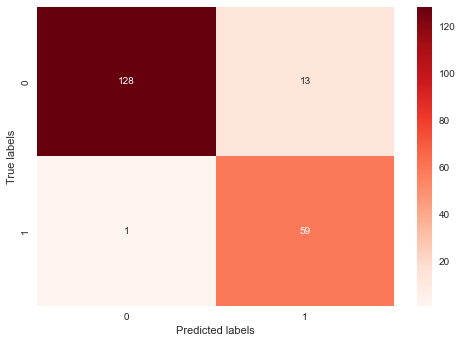

In [18]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [19]:
f1_score(y_test, y_pred)

0.893939393939394

In [20]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

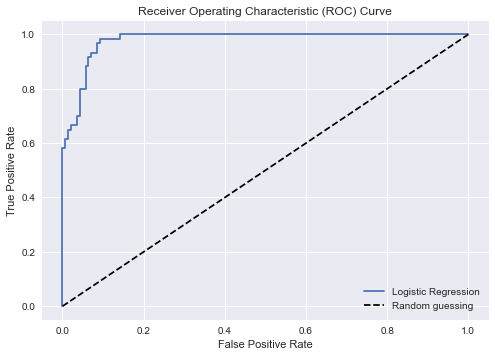

In [21]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [22]:
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [87],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'class_weight': [{0: .46, 1: .51}]
}
rf = RandomForestClassifier(random_state= 42)

In [23]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.46, 1: 0.51}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 87}
Best score: 0.8766712029442421


In [24]:
auc2 = roc_auc_score(y_test, proba[:,1], multi_class='auto')
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9808510638297873
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       141
           1       0.84      0.97      0.90        60

    accuracy                           0.94       201
   macro avg       0.91      0.94      0.93       201
weighted avg       0.94      0.94      0.94       201



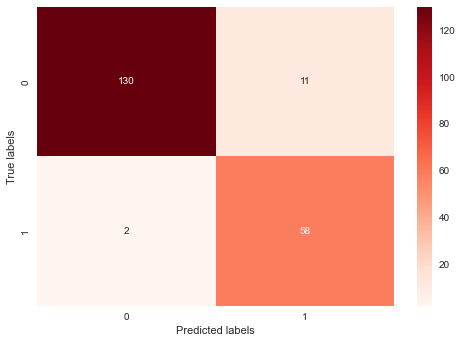

In [25]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [26]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

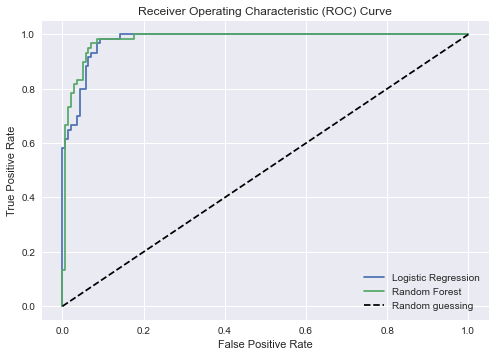

In [27]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [28]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [29]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.92413484023748


In [30]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [31]:
auc3 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9888888888888889
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       141
           1       0.84      0.97      0.90        60

    accuracy                           0.94       201
   macro avg       0.91      0.94      0.93       201
weighted avg       0.94      0.94      0.94       201



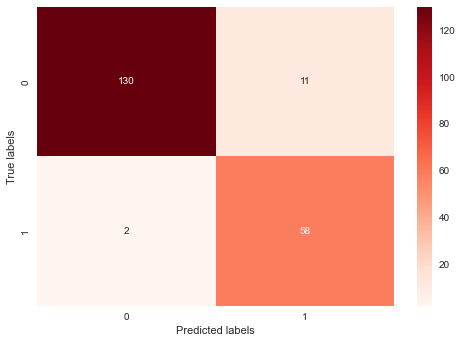

In [32]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [33]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

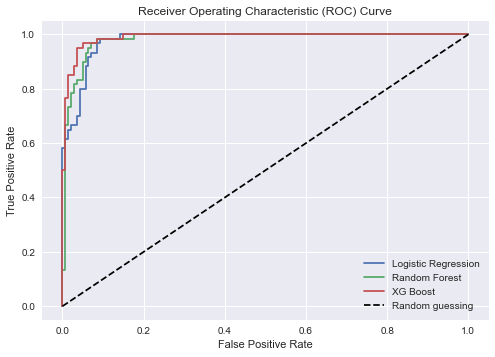

In [34]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [35]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [36]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [37]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
20/20 [==============================] - 2s 17ms/step - loss: 0.6882 - precision: 0.3456 - recall: 0.4455 - val_loss: 0.5896 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5590 - precision: 0.7000 - recall: 0.0332 - val_loss: 0.5195 - val_precision: 0.9333 - val_recall: 0.2692
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 0.4858 - precision: 0.7750 - recall: 0.5877 - val_loss: 0.4459 - val_precision: 0.9200 - val_recall: 0.4423
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.4070 - precision: 0.8129 - recall: 0.6588 - val_loss: 0.3723 - val_precision: 0.8140 - val_recall: 0.6731
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 0.3421 - precision: 0.7761 - recall: 0.7393 - val_loss: 0.3144 - val_precision: 0.8070 - val_recall: 0.8846
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 0.2895 - precision:

20/20 [==============================] - 0s 4ms/step - loss: 0.0244 - precision: 0.9814 - recall: 1.0000 - val_loss: 0.1447 - val_precision: 0.9400 - val_recall: 0.9038
Epoch 47/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0218 - precision: 0.9906 - recall: 1.0000 - val_loss: 0.1200 - val_precision: 0.9273 - val_recall: 0.9808
Epoch 48/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0212 - precision: 0.9860 - recall: 1.0000 - val_loss: 0.1228 - val_precision: 0.9273 - val_recall: 0.9808
Epoch 49/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0189 - precision: 0.9906 - recall: 1.0000 - val_loss: 0.1267 - val_precision: 0.9259 - val_recall: 0.9615
Epoch 50/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0190 - precision: 0.9860 - recall: 1.0000 - val_loss: 0.1315 - val_precision: 0.9412 - val_recall: 0.9231


In [38]:
y_ = ann.predict(X_test)

7/7 [==============================] - 0s 3ms/step


In [39]:
y_= y_.reshape(y_.shape[0],)

In [40]:
y_pred= np.array([round(i+.25) for i in y_])

In [41]:
auc4 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9820330969267139
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       141
           1       0.84      0.97      0.90        60

    accuracy                           0.94       201
   macro avg       0.91      0.94      0.93       201
weighted avg       0.94      0.94      0.94       201



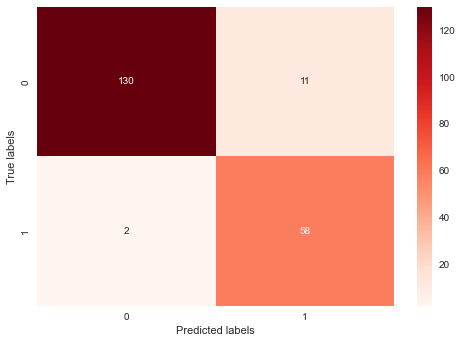

In [42]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [43]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

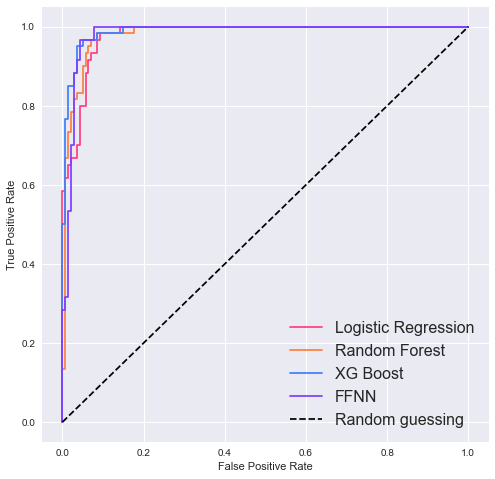

In [44]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff3f7f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f3f")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#3f7fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f3fff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_alg.png")
plt.show()

## Model Evaluations

In [45]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9303 & 0.9353 & 0.9353 & 0.9353 \\
   Recall & 0.9833 & 0.9667 & 0.9667 & 0.9667 \\
Precision & 0.8194 & 0.8406 & 0.8406 & 0.8406 \\
 F1-Score & 0.8939 & 0.8992 & 0.8992 & 0.8992 \\
      AUC & 0.9787 & 0.9809 & 0.9889 & 0.9820 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [46]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [47]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [48]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-1.3688450120134301, 5.689016628117737, 0.15143803640302703)

In [49]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [50]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.21540278428980417)

In [51]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-0.4137462415669881, 1.2436855629597985, -0.024092983345281125)

In [52]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [53]:
IND_fin["access"] = 1- IND_fin["access"]
#IND_fin["usage"] = 1- IND_fin["usage"]

In [54]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [55]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

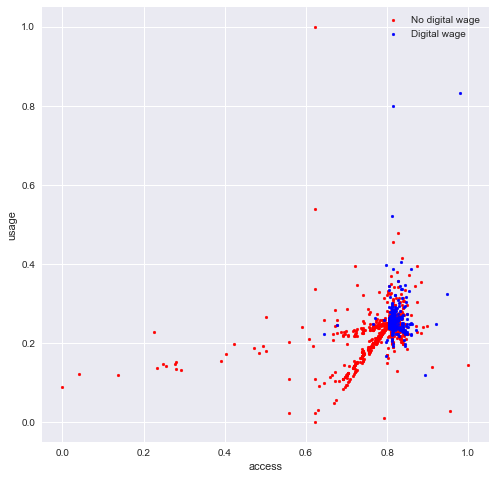

In [56]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.25,1.05])
#plt.ylim([-0.05,.75])
plt.savefig('../../images/find_alg')
plt.show()

In [57]:
IND_fin['access'].describe()

count    1002.000000
mean        0.784597
std         0.083763
min         0.000000
25%         0.771752
50%         0.810027
75%         0.816934
max         1.000000
Name: access, dtype: float64

In [58]:
IND_fin['usage'].describe()

count    1002.000000
mean        0.235095
std         0.064743
min         0.000000
25%         0.213706
50%         0.242015
75%         0.256695
max         1.000000
Name: usage, dtype: float64

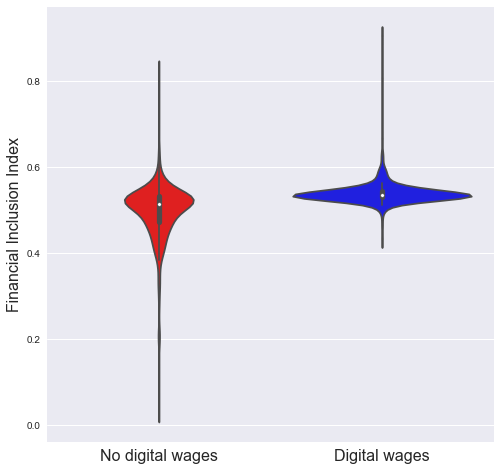

In [59]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)
plt.savefig('../../images/ind_alg')

# Show the plot
plt.show()

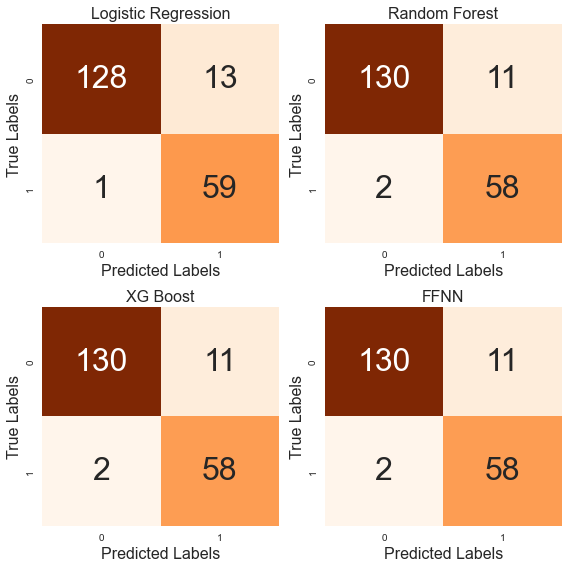

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="Oranges", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_alg.png')
# Display the plot
plt.show()

## Feature importance

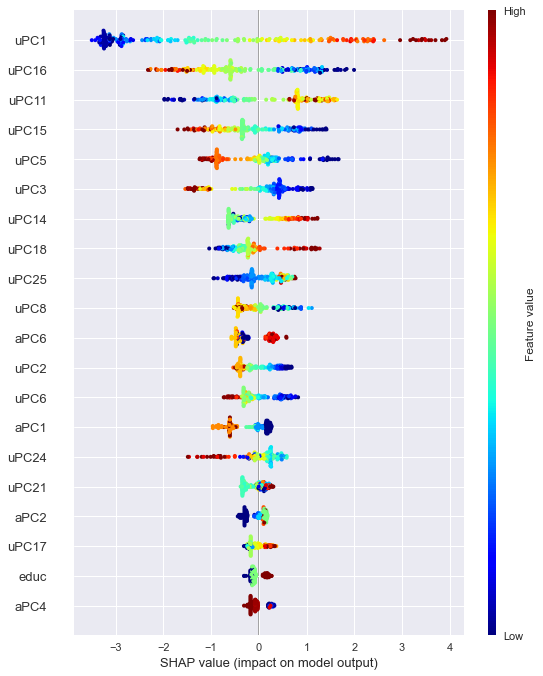

In [85]:
explainer = shap.TreeExplainer(best_xgb)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test, cmap= "jet")

In [62]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

In [73]:
a= a[['aPC6', 'aPC1', 'aPC2', 'aPC4']]
u= u[['uPC1', 'uPC16', 'uPC11', 'uPC15', 'uPC5', 'uPC3', 'uPC14', 'uPC18', 'uPC25', 'uPC8', 'uPC2', 
      'uPC6', 'uPC24', 'uPC21', 'uPC17']]

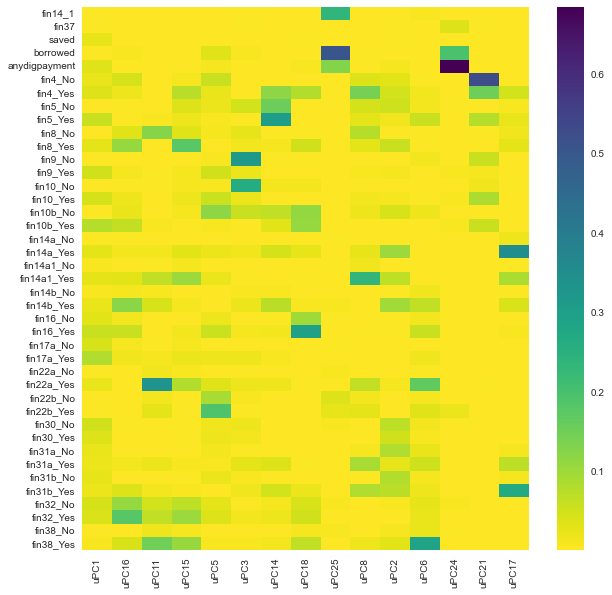

In [80]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_alg.png')
plt.show()

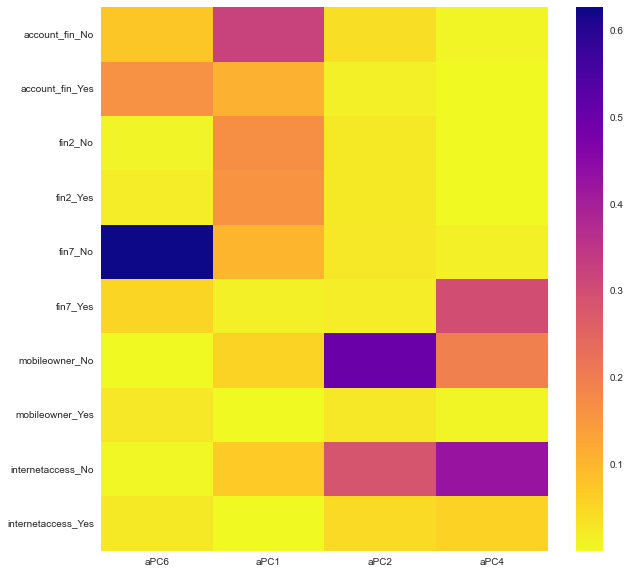

In [75]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_alg.png')
plt.show()

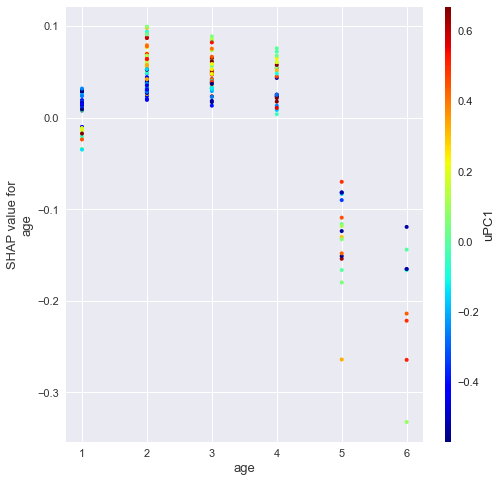

In [86]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

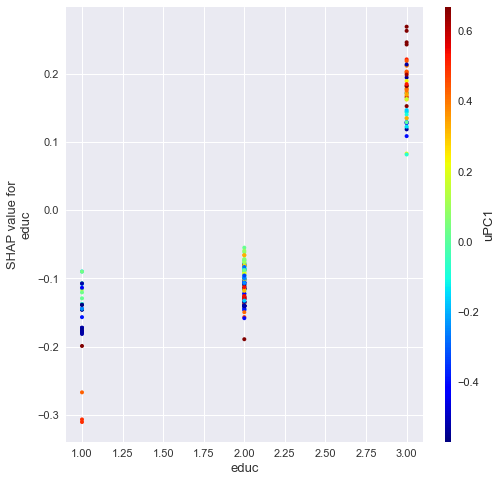

In [87]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

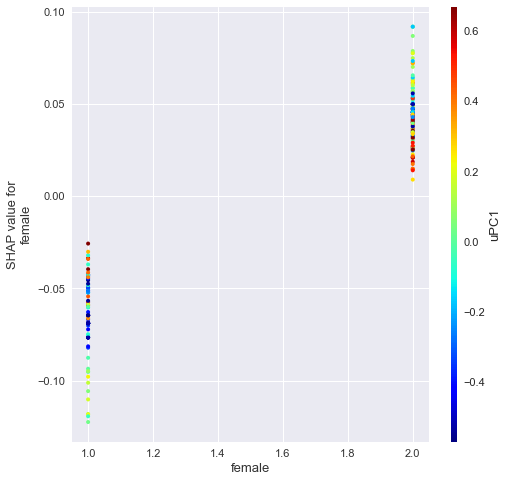

In [88]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

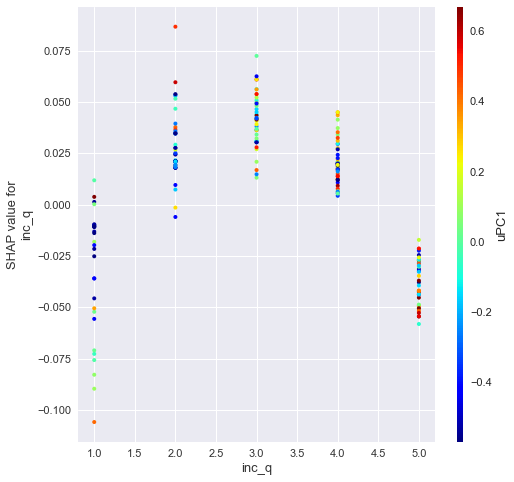

In [89]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

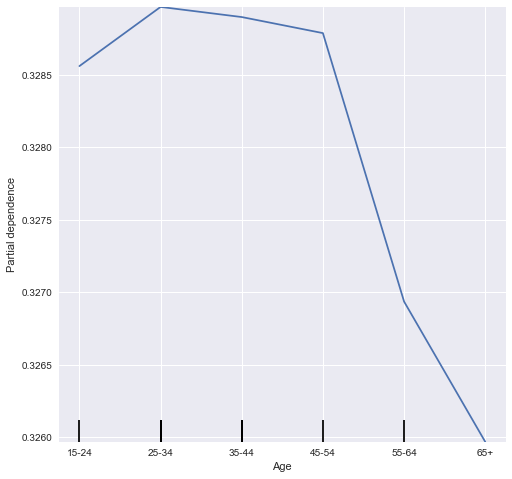

In [121]:
fig, ax= plt.subplots(figsize=(8,8))
p_age= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['age'], ax=ax)
new_labels = ['15-24', '25-34', '35-44', '45-54', '55-64', '65+']
x=[1,2,3,4,5,6]
plt.xticks(x, new_labels)
plt.xlabel('Age')
plt.savefig('../../images/pd_age_alg.png')
plt.show()

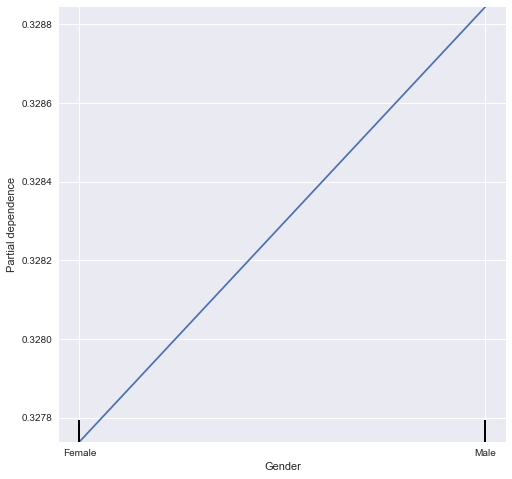

In [122]:
fig, ax= plt.subplots(figsize=(8,8))
p_female= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['female'], ax=ax)
new_labels = ['Female', 'Male']
x=[1,2]
plt.xticks(x, new_labels)
plt.xlabel('Gender')
plt.savefig('../../images/pd_gen_alg.png')
plt.show()

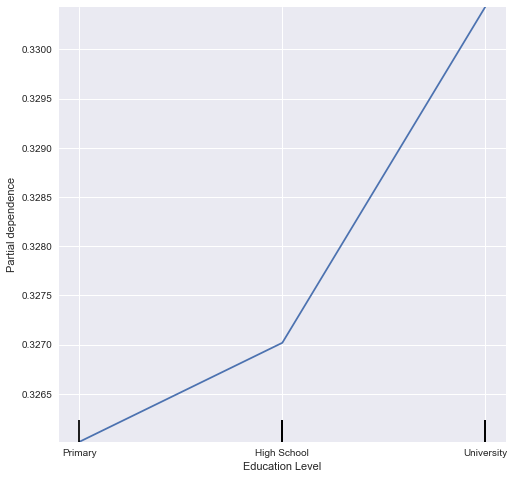

In [123]:
fig, ax= plt.subplots(figsize=(8,8))
p_educ= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['educ'], ax=ax)
new_labels = ['Primary', 'High School', 'University']
x=[1,2,3]
plt.xticks(x, new_labels)
plt.xlabel('Education Level')
plt.savefig('../../images/pd_educ_alg.png')
plt.show()

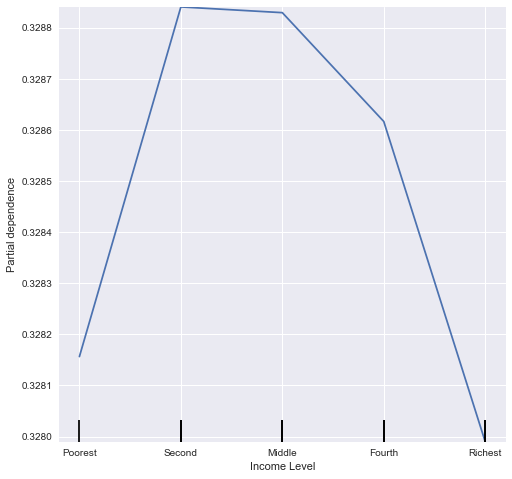

In [124]:
fig, ax= plt.subplots(figsize=(8,8))
p_inc= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['inc_q'], ax=ax)
new_labels = ['Poorest', 'Second', 'Middle', 'Fourth', 'Richest']
x=[1,2,3,4,5]
plt.xticks(x, new_labels)
plt.xlabel('Income Level')
plt.savefig('../../images/pd_inc_alg.png')
plt.show()